## Preamble

Import modules, define classes and functions and constants, etc.

In [1]:
import ws3.forest, ws3.core

In [3]:
data_path = 'data/input'
# fert_codes = ['00',
#               '11',
#               '12',
#               '13',
#               '14',
#               '15',
#               '16',
#               '17',
#               '21',
#               '22',
#               '23',
#               '24',
#               '25',
#               '26',
#               '31',
#               '32',
#               '33',
#               '34',
#               '35']
period_length = 10
max_age = 350
base_year = 2020
horizon = 10
# curve_table = pd.read_csv('%s/curve_table.csv' % data_path)
model_name = 'tsa24_clipped'

# Create a new `ForestModel` instance

In [4]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [5]:
fm.import_landscape_section()

In [6]:
fm.import_areas_section()

0

In [7]:
fm.import_yields_section()

('?', '?', '?', '?', '?') 5
('?', '?', '2402000', '?', '2422000') 1
('?', '?', '2403000', '?', '2423000') 1
('?', '?', '2403001', '?', '2423001') 0
('?', '?', '2401002', '?', '2421002') 1
('?', '?', '2402002', '?', '2422002') 1
('?', '?', '2403002', '?', '2423002') 1
('?', '?', '2402003', '?', '2422003') 0
('?', '?', '2403003', '?', '2423003') 0
('?', '?', '2402004', '?', '2422004') 0
('?', '?', '2403004', '?', '2423004') 0
('?', '?', '2401007', '?', '2421007') 0
('?', '?', '2402007', '?', '2422007') 0
('?', '?', '2403007', '?', '2423007') 0
('?', '?', '2402000', '?', '2422110') 0
('?', '?', '2403000', '?', '2423110') 0
('?', '?', '2403001', '?', '2423111') 0
('?', '?', '2401002', '?', '2421112') 0
('?', '?', '2402002', '?', '2422112') 0
('?', '?', '2403002', '?', '2423112') 0
('?', '?', '2402003', '?', '2422113') 0
('?', '?', '2403003', '?', '2423113') 0
('?', '?', '2402004', '?', '2422114') 0
('?', '?', '2403004', '?', '2423114') 0
('?', '?', '2401007', '?', '2421117') 0
('?', '?', '

In [8]:
fm.import_actions_section()

In [9]:
fm.import_transitions_section()

In [10]:
fm.compile_actions()

In [11]:
fm.initialize_areas()
fm.reset_actions()

# Define a base scenario (add optimization problem)

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [19]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return 

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for actionned area (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for actionned area (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, list of action codes, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`).

In [ ]:
def _gen_scen_base(fm, name='base', util=0.85, harvest_acode='cc',  
                   tvy_name='volume', obj_mode='max_hvol', mask=None):
    from functools import partial
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}

    # define list of action codes
    acodes = ['null', harvest_acode]  
    
    # define volume expression
    vexpr = '%s * %0.2f' % (tvy_name, util)

    # switch between 'max harvest volume' and 'min harvest area' objective function modes
    if obj_mode == 'max_hvol':
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_harea':
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)

    # define objective function coefficient function
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) 
    
    T = fm.periods
    
    # define even flow constraint (on harvest volume)
    cname = 'cflw_acut'
    e = 0.1 # this is a big number! (maybe make a smaller value for production code)
    coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
    cflw_e[cname] = {t:e for t in T}          
    
    # define even flow constraint (on harvest area)
    cname = 'cflw_vcut'
    e = 0.1 # this is a big number! (maybe make a smaller value for production code)
    coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
    cflw_e[cname] = {t:e for t in T}          
    
    # define general constraint (growing stock)
    cname = 'cgen_gs'
    lb, ub = 0., 1000000000000.
    coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
    cgen_data[cname] = {'lb':{lb for t in T}, 'ub':{ub for t in T}}
    
    
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)


In [ ]:
def _gen_scen_base(fm, param_funcs, name='base', util=0.85, param_funcs=None, harvest_acode='harvest',  
                   tvy_name='totvol', toffset=0, obj_mode='max_hvol', target_path='./input/targets.csv',
                   max_tp=2074, cacut=None, mask=None):
    from functools import partial
    acodes = ['null', harvest_acode]  
    vexpr = '%s * %0.2f' % (tvy_name, util)
    if obj_mode == 'max_hvol':
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_harea':
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)
        
    # if not param_funcs:
    #     df_targets = pd.read_csv(target_path).set_index(['tsa', 'year'])
    #     param_funcs = {}
    #     param_funcs['cvcut'] = lambda bn, t: float(df_targets.loc[bn, t]['vcut']) if t <= max_tp else float(df_targets.loc[bn, max_tp]['vcut'])
    #     param_funcs['cabrn'] = lambda bn, t: float(df_targets.loc[bn, t]['abrn']) if t <= max_tp else float(df_targets.loc[bn, max_tp]['abrn'])
    #     param_funcs['cflw_acut_e'] = lambda bn, t: df_targets.loc[bn, t]['cflw_acut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cflw_acut_e']
    #     param_funcs['cgen_vcut_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_vcut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_vcut_e']
    #     param_funcs['cgen_acut_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_vcut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_vcut_e']
    #     param_funcs['cgen_abrn_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_abrn_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_abrn_e']
    coeff_funcs = {'z':partial(cmp_c_z, expr=zexpr)}
    coeff_funcs.update({'cacut_%s' % bn:partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=(bn, '?', '?', '?')) 
                        for bn in basenames})
    coeff_funcs.update({'cvcut_%s' % bn:partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=(bn, '?', '?', '?')) 
                        for bn in basenames})
    T = fm.periods# [fm.base_year+(t-1)*fm.period_length for t in fm.periods]
    cflw_e, cgen_data = {}, {}
    #foo = {bn:{t:(bn, t+toffset) for t in T} for bn in basenames}
    #print(T)
    #assert False
    #cflw_ebn = {bn:({t:param_funcs['cflw_acut_e'](bn, fm.base_year+(t-1)*fm.period_length+toffset) for t in T}, 1) for bn in basenames}
    #cflw_e.update({'cacut_%s'%bn:cflw_ebn[bn] for bn in basenames})
    for bn in basenames:
        #print(df_targets.loc[bn])
        cgen_data.update({'cvcut_%s' % bn:{'lb':{t:param_funcs['cvcut'](bn, fm.base_year+(t-1)*fm.period_length+toffset) *
                                                 (1. - param_funcs['cgen_vcut_e'](bn, fm.base_year+(t-1)*fm.period_length+toffset))
                                               for t in T}, 
                                         'ub':{t:param_funcs['cvcut'](bn, fm.base_year+(t-1)*fm.period_length+toffset) for t in T}}})
        if cacut:
            cgen_data.update({'cacut_%s' % bn:{'lb':{t:param_funcs['cacut'](bn, fm.base_year+(t-1)*fm.period_length)*
                                                   (1. - param_funcs['cgen_acut_e'](bn, fm.base_year+(t-1)*fm.period_length)) for t in T}, 
                                             'ub':{t:param_funcs['cacut'](bn, fm.base_year+(t-1)*fm.period_length) for t in T}}})
    #print(cflw_e)
    fm._tmp = {}
    fm._tmp['param_funcs'] = param_funcs
    fm._tmp['cgen_data'] = cgen_data
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)


def gen_scen(fm, basenames, name, util, param_funcs, toffset=0, obj_mode='max_hvol', cacut=None, mask=None, target_path='./input/targets.csv'):
    dsp = {'base':_gen_scen_base}
    return dsp[name](fm, basenames, name, util, param_funcs=param_funcs, toffset=toffset, obj_mode=obj_mode, cacut=cacut, mask=mask, target_path=target_path)


In [12]:
import pandas as pd
import ws3.forest, ws3.core

The default `ws3.forest.GreedyAreaSelector` is broken. This is basically just a copy of that but patched. Need to fix this ASAP and push a patch up to the GitHub repo.

In [2]:
class GreedyAreaSelector:
    """
    Default AreaSelector implementation. Selects areas for treatment from oldest age classes.
    """
    def __init__(self, parent):
        self.parent = parent

    def operate(self, period, acode, target_area, mask=None,
                commit_actions=True, verbose=False):
        """
        Greedily operate on oldest operable age classes.
        Returns missing area (i.e., difference between target and operated areas).
        """
        key = lambda item: max(item[1])
        odt = sorted(list(self.parent.operable_dtypes(acode, period, mask).items()), key=key)
        print(' entering selector.operate()', len(odt), 'operable dtypes')
        while target_area > 0 and odt:
            while target_area > 0 and odt:
                popped = odt.pop()
                try:
                    dtk, ages = popped #odt.pop()
                except:
                    print(odt)
                    print(popped)
                    raise
                age = sorted(ages)[-1]
                oa = self.parent.dtypes[dtk].operable_area(acode, period, age)
                if not oa: continue # nothing to operate
                area = min(oa, target_area)
                target_area -= area
                if area < 0:
                    print('negative area', area, oa, target_area, acode, period, age)
                    assert False
                if verbose:
                    print(' selector found area', [' '.join(dtk)], acode, period, age, area)
                self.parent.apply_action(dtk, acode, period, age, area, 
                                         fuzzy_age=False, recourse_enabled=False, 
                                         compile_c_ycomps=True, verbose=verbose)
            odt = sorted(list(self.parent.operable_dtypes(acode, period, mask).items()), key=key)
        self.parent.commit_actions(period, repair_future_actions=True)
        if verbose:
            print('GreedyAreaSelector.operate done (remaining target_area: %0.1f)' % target_area)
        return target_area

Define a function that implements a greedy (oldest-first) priority queue heuristic harvest scheduling heuristic (including auto-parametrizing the periodic harvest area target with some bootstrap analysis of the yield curves we built into the model). Just for quick and dirty testing purposes (less finnicky that formulating and solving an optimization problem, and also does not require a working `gurobi` solver). 

In [3]:
# copy function definition for debugging
def schedule_harvest_areacontrol(fm, period=1, acode='cc', util=0.85, 
                                 target_masks=None, target_areas=None, target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    #fm.reset_actions()
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ? ?' % au
                masked_area = fm.inventory(0, mask=mask)
                #print(mask, masked_area)
                if masked_area > mask_area_thresh:
                    #print(masked_area, mask_area_thresh)
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
                #print(au_vals)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                if fm.inventory(0, mask='? ? areacontrol_au_agg ? ?') > mask_area_thresh:
                    au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ? ?' % au for au in au_vals]
            #print(au_vals)
            #print(target_masks)
        print(target_masks, au_vals)
        #assert False
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('volume').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            #awr = []
            #dtype_keys = fm.unmask(mask)
            #for dtk in dtype_keys:
            #    dt = fm.dtypes[dtk]
            #    awr.append(dt.ycomp('totvol').mai().ytp().lookup(0) * dt.area(0))
            #r = sum(awr)  / masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            print(i)
            print(mask)
            print(masked_area)
            ta = (1/r) * fm.period_length * masked_area * asf
            target_areas.append(ta)
    for mask, target_area in zip(target_masks, target_areas):
        if verbose > 0:
            print('calling areaselector', period, acode, target_area, mask)
        fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

Define some constrants and such.

In [4]:
data_path = 'data/input/'
fert_codes = ['00',
              '11',
              '12',
              '13',
              '14',
              '15',
              '16',
              '17',
              '21',
              '22',
              '23',
              '24',
              '25',
              '26',
              '31',
              '32',
              '33',
              '34',
              '35']
period_length = 10
max_age = 350
base_year = 2020
horizon = 10
curve_table = pd.read_csv('%s/curve_table.csv' % data_path)
model_name = 'tsa24_clipped'

Import CSV files with yield curve data and reformat the Woodstock-style YIELDS format. 

In [11]:
lines = []
for fert in fert_codes:
    au_table = pd.read_csv('%s/au_table_%s.csv' % (data_path, fert)).set_index('au_id')
    au_table = au_table.query('tsa == 24')
    au_table['thlb'] = au_table.apply(lambda row: 0 if row.unmanaged_curve_id == row.managed_curve_id else 1, axis=1)
    curve_points_table = pd.read_csv('%s/curve_points_table_updated_%s.csv' % (data_path, fert)).set_index('curve_id')
    for au_id, au_row in au_table.iterrows():
        print(au_id)
        if au_row.thlb == 0:
            fert_curve_id = au_row.fert_curve_id #apply curve id 
            managed_curve_id = au_row.managed_curve_id
            curve_id = au_row.managed_curve_id 
            mask = ('?', '?', str(au_id), '?', str(managed_curve_id))
            print('foo')
            #continue # continue is optional here
        else:
            fert_curve_id = au_row.fert_curve_id #apply curve id 
            managed_curve_id = au_row.managed_curve_id
            curve_id = au_row.fert_curve_id
            mask = ('?', '?', str(au_id), '?', str(fert_curve_id))
        print('bar')
        print(mask)
        lines.append('*Y %s\n' % ' '.join(v for v in mask))
        #print(lines[-1])
        for i, col in enumerate(curve_points_table.columns):
            if i == 0:
                continue 
            yname = col
            points = [(r.age, r[col]) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.age % period_length and r.age <= max_age]
            # print(points)
            c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
            #fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
            #fm.ynames.add(yname) # only if not already present?
            if not au_row.thlb: continue
            lines.append('%s 1 %s\n' % (yname, ' '.join(str(int(c[x])) for x in range(0, 300, 1))))
            #print(lines[-1])
            #for dtk in fm.unmask(mask): 
            #    # print(au_id, is_managed, curve_id, mask, yname, dtk)
            #    fm.dtypes[dtk].add_ycomp('a', yname, c)
            print()
    #assert False
    
filename = '%s/%s.yld' % (data_path, model_name)
print(filename)
with open(filename, 'w') as snk:
    snk.writelines(lines)

2401000
foo
bar
('?', '?', '2401000', '?', '2401000')


KeyError: 2401000

In [41]:
# harvesting

acode = 'cc'
print('*CASE', acode)
for au_id, au_row in au_table.iterrows():
    if not au_row.thlb: continue
    curve_id = au_row.managed_curve_id
    target_curve_id = au_row.managed_curve_id
    smask = ' '.join(('?', '?', str(au_id), '?', '?'))
    tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
    print('*SOURCE', smask)
    print('*TARGET', tmask, '100')
print('')
    
fert_once = list(range(11, 18))
fert_twice = list(range(21,27))
fert_thrice = list(range(31,36))
fert_option_all = fert_once + fert_twice + fert_thrice
for i in fert_once:
    acode = 'f%i' % i
    print('*CASE', acode)
    for au_id, au_row in au_table.iterrows():
        if not au_row.thlb: continue
        curve_id = au_row.managed_curve_id
        target_curve_id = curve_id + i * 10
        smask = ' '.join(('?', '?', str(au_id), '?', '?'))
        tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
        print('*SOURCE', smask)
        print('*TARGET', tmask, '100')
print('')

for i in fert_twice:
    acode = 'f%i' % i
    print('*CASE', acode)
    for au_id, au_row in au_table.iterrows():
        if not au_row.thlb: continue
        curve_id = au_row.managed_curve_id
        target_curve_id = curve_id + i * 10
        smask = ' '.join(('?', '?', str(au_id), '?', '?'))
        tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
        print('*SOURCE', smask)
        print('*TARGET', tmask, '100')    
print('')

for i in fert_thrice:
    acode = 'f%i' % i
    print('*CASE', acode)
    for au_id, au_row in au_table.iterrows():
        if not au_row.thlb: continue
        curve_id = au_row.managed_curve_id
        target_curve_id = curve_id + i * 10
        smask = ' '.join(('?', '?', str(au_id), '?', '?'))
        tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
        print('*SOURCE', smask)
        print('*TARGET', tmask, '100')    
        


'''
*CASE f15
*SOURCE ? ? 2421002 ? ?
*TARGET ? ? ? ? 2421152 100
*SOURCE ? ? 2422002 ? ?
*TARGET ? ? ? ? 2422152 100
'''

*CASE cc
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422000 100
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423000 100
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423001 100
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421002 100
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422002 100
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423002 100
*SOURCE ? ? 2402003 ? ?
*TARGET ? ? ? ? 2422003 100
*SOURCE ? ? 2403003 ? ?
*TARGET ? ? ? ? 2423003 100
*SOURCE ? ? 2402004 ? ?
*TARGET ? ? ? ? 2422004 100
*SOURCE ? ? 2403004 ? ?
*TARGET ? ? ? ? 2423004 100
*SOURCE ? ? 2401007 ? ?
*TARGET ? ? ? ? 2421007 100
*SOURCE ? ? 2402007 ? ?
*TARGET ? ? ? ? 2422007 100
*SOURCE ? ? 2403007 ? ?
*TARGET ? ? ? ? 2423007 100

*CASE f11
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422110 100
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423110 100
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423111 100
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421112 100
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422112 100
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423

'\n*CASE f15\n*SOURCE ? ? 2421002 ? ?\n*TARGET ? ? ? ? 2421152 100\n*SOURCE ? ? 2422002 ? ?\n*TARGET ? ? ? ? 2422152 100\n'

OK. Lets create a model from the input files now.

In [109]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [110]:
fm.import_landscape_section()

In [111]:
fm.import_areas_section()

0

In [112]:
fm.import_yields_section()

('?', '?', '?', '?', '?') 7
('?', '?', '2402000', '?', '2422000') 1
('?', '?', '2403000', '?', '2423000') 1
('?', '?', '2403001', '?', '2423001') 0
('?', '?', '2401002', '?', '2421002') 1
('?', '?', '2402002', '?', '2422002') 1
('?', '?', '2403002', '?', '2423002') 1
('?', '?', '2402003', '?', '2422003') 0
('?', '?', '2403003', '?', '2423003') 0
('?', '?', '2402004', '?', '2422004') 0
('?', '?', '2403004', '?', '2423004') 0
('?', '?', '2401007', '?', '2421007') 0
('?', '?', '2402007', '?', '2422007') 0
('?', '?', '2403007', '?', '2423007') 0
('?', '?', '2402000', '?', '2422110') 0
('?', '?', '2403000', '?', '2423110') 0
('?', '?', '2403001', '?', '2423111') 0
('?', '?', '2401002', '?', '2421112') 0
('?', '?', '2402002', '?', '2422112') 0
('?', '?', '2403002', '?', '2423112') 0
('?', '?', '2402003', '?', '2422113') 0
('?', '?', '2403003', '?', '2423113') 0
('?', '?', '2402004', '?', '2422114') 0
('?', '?', '2403004', '?', '2423114') 0
('?', '?', '2401007', '?', '2421117') 0
('?', '?', '

In [113]:
fm.import_actions_section()

In [114]:
fm.import_transitions_section()

In [115]:
fm.compile_actions()

In [132]:
fm.initialize_areas()
fm.reset_actions()

In [133]:
fm.areaselector = GreedyAreaSelector(fm)

In [134]:
#schedule_harvest_areacontrol(fm, period=1, verbose=1)

In [135]:
for period in fm.periods:
    schedule_harvest_areacontrol(fm, period=period, verbose=1)

adding to au_agg ? 1 2401004 ? ? 0.0
adding to au_agg ? 1 2401005 ? ? 0.0
adding to au_agg ? 1 2403005 ? ? 0.0
adding to au_agg ? 1 2401000 ? ? 0.0
adding to au_agg ? 1 2402007 ? ? 0.0
adding to au_agg ? 1 2402006 ? ? 0.0
adding to au_agg ? 1 2402003 ? ? 0.0
adding to au_agg ? 1 2403004 ? ? 0.0
adding to au_agg ? 1 2403007 ? ? 0.0
adding to au_agg ? 1 2401001 ? ? 0.0
adding to au_agg ? 1 2403006 ? ? 0.0
adding to au_agg ? 1 2402004 ? ? 0.0
adding to au_agg ? 1 2403003 ? ? 0.0
adding to au_agg ? 1 2401007 ? ? 0.0
adding to au_agg ? 1 2401003 ? ? 0.0
adding to au_agg ? 1 2401006 ? ? 0.0
adding to au_agg ? 1 2403001 ? ? 0.0
adding to au_agg ? 1 2402001 ? ? 0.0
adding to au_agg ? 1 2402005 ? ? 0.0
['? 1 2402000 ? ?', '? 1 2401002 ? ?', '? 1 2403000 ? ?', '? 1 2402002 ? ?', '? 1 2403002 ? ?', '? 1 areacontrol_au_agg ? ?'] ['2402000', '2401002', '2403000', '2402002', '2403002', 'areacontrol_au_agg']
0
? 1 2402000 ? ?
0.638005468748551
1
? 1 2401002 ? ?
964.0243132741266
2
? 1 2403000 ? ?
14.

In [136]:
pareas = [fm.compile_product(period, '1.') for period in fm.periods]

In [137]:
pvols = [fm.compile_product(period, 'volume') for period in fm.periods]

In [138]:
df = pd.DataFrame({'period':fm.periods, 'areas':pareas, 'vols':pvols})
df

,period,areas,vols
0,1,94.973291,22531.131181
1,2,92.729300,21086.509199
2,3,92.729300,20134.991777
3,4,92.729300,19086.101134
4,5,92.729300,17130.927310
5,6,92.729300,15646.477603
6,7,92.729300,15322.430026
7,8,92.729300,14204.921519
8,9,92.729300,14037.395745
9,10,92.729300,14235.866966


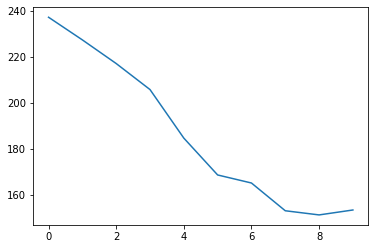

In [139]:

/df.areas).plot()